# Lecture 9 - Time Series Analysis and Sun Spots

Last lecture we looked in detail at Fourier Analysis and the FFT.

Today we are going to apply that to a _real data set_ and look more into _plotting and working with times series data_. 

The file _/data/dayssn.dat_ contains the daily sunspot number from December 23 1848 until May 31 2015, this is one of longest data recordings in Astronomical Science. 

## Sunspots

Sunspots form in pairs of opposite polarity magnetic field (one north and one south) with reduced temperature as compared to their surroundings (why they're dark). 

The intesnse magnetic fields and opposite polarity of sunspot pairs lead to the development of coronal loops, prominences, solar flares and coronoal mass ejections which drive Space Weather throughout our solar system.

The number of sunspots varies with solar cycle, peaking at _solar maximum_, declining during the _delcining phase_, reaching a minimum at _solar minimum_ and then increasing again during the _ascending phase_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # helps formatting
import datetime # helps matplotlib deal with date strings and conversion

import numpy as np

from datetime import datetime

#dates = np.loadtxt('../data/dayssn.dat', usecols=[0],dtype='|S8',converters={ 0: mdates.strpdate2num('%Y%m%d')})

# read in two columns of data
#  column 0 and 2, ignore column 1
dates, ssn = np.loadtxt('../data/dayssn.dat', unpack=True,usecols=[0,2], converters={0: mdates.bytespdate2num('%Y%m%d')})

print(ssn.size,ssn.dtype)
print(dates.size,dates.dtype)


60790 float64
60790 float64


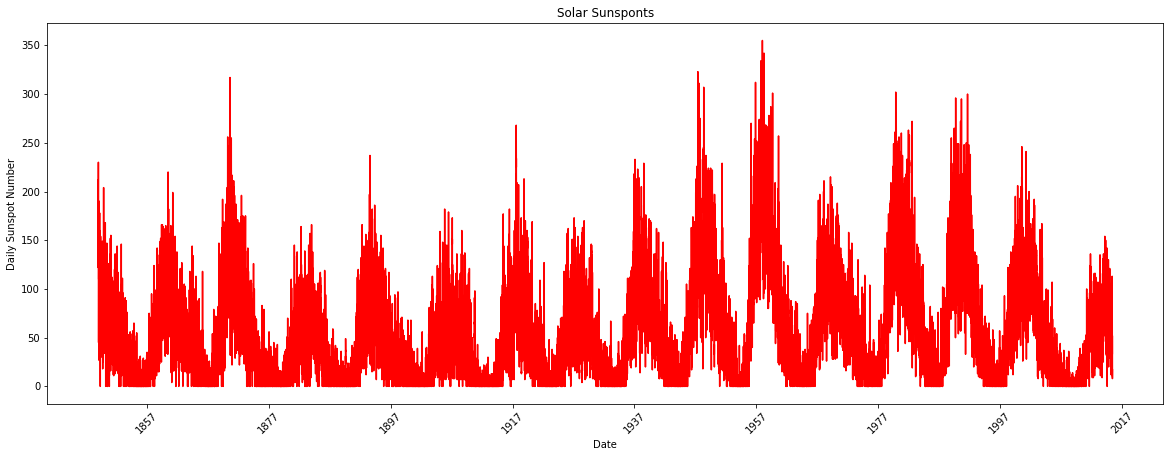

In [2]:
# plot the sunspots
f, ax = plt.subplots(figsize=(20,7))

ax.plot_date(dates,ssn,fmt="r-")
ax.set_xlabel('Date')
ax.set_ylabel('Daily Sunspot Number')
ax.set_title('Solar Sunsponts')
ax.xaxis.set_tick_params(rotation=45)

## The FFT and power spectra

In the above it is clear that the number of sunspots oscillates with time. But what is the frequency, or period, of that oscialltion? 

In [3]:
# Import the FFT 
from scipy.fftpack import fft
# Window functions
import scipy.signal as signal

# compute the FFT of the sunspot
#  dataset 

npts = ssn.size 
res  = 1*24.*60.*60.

# calculate the FFT
fssn  = fft(ssn)

# calculate power
pssn = 2.*abs(np.copy(fssn[0:npts//2]))**2./npts**2
pssn[0] = pssn[0]/2.
pssn[npts//2-1] = pssn[npts//2-1]/2.
# calculate the frequency axis
f = np.arange(npts//2)*(1/(npts*res)) 


[Text(0,0.5,'Log Power - $counts^2$'), Text(0.5,0,'Log Frequency - Hz')]

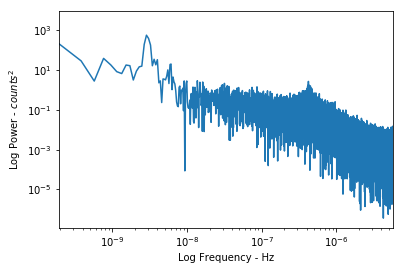

In [4]:
# plot the power
f1, ax1 = plt.subplots()

ax1.plot(f,pssn)
ax1.set(yscale='log',xlim=[f[1],f.max()],xscale='log')
ax1.set(ylabel='Log Power - $counts^2$',xlabel='Log Frequency - Hz')



In the above we see evidence for peaks in power at fixed frequencies, ~3E-9 Hz (3.3E8 s), ~6E-9 Hz (1.6E8 s), and 3-4E-7 Hz (2.5-3.3E6 s). 

What do these frequencies represent, note there are 86400 s in a day?


## Windowing
Can we clean the power spectra up by windowing?

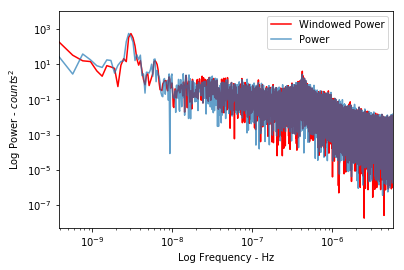

In [5]:
# Import signal library so 
#  we can utalize built in windows
import scipy.signal as signal

# calculate the window
#  and window correction
win    = signal.blackmanharris(npts)
win_c  = npts*np.sum(win**2)

# calculate the winow'ed FFT
fssn2  = fft(ssn*win)

# calculate power
pssn2 = 2.*abs(np.copy(fssn2[0:npts//2]))**2.
pssn2[0] = pssn2[0]/2.
pssn2[npts//2-1] = pssn2[npts//2-1]/2.
# apply window correction
pssn2 = pssn2/win_c

# plot window'ed power
f2, ax2 = plt.subplots()

ax2.plot(f,pssn2,label='Windowed Power', color='r')
ax2.plot(f,pssn, label='Power',alpha=0.7)
ax2.set(yscale='log',xlim=[f[2],f.max()],xscale='log')
ax2.set(ylabel='Log Power - $counts^2$',xlabel='Log Frequency - Hz')
ax2.legend()

## The Periodogram 

The [SciPy Periodogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram) simplifies the above to a few lines of code while offering additional utility.
- Power Spectra, units $X^2$
- Power Spectral Desnity, units $X^2/Hz$
- Detrending

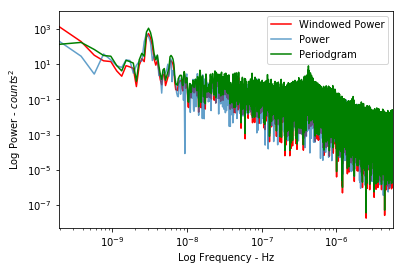

In [6]:
# Sampling Frequency
fs = 1./(res)

# Get frequency axis and window'ed power spectra
fp, p_spec = signal.periodogram(ssn, fs, 'blackmanharris', scaling='spectrum',detrend='linear')

# plot periodogram
f3, ax3 = plt.subplots()

ax3.plot(f,pssn2,label='Windowed Power', color='r')
ax3.plot(f,pssn, label='Power',alpha=0.7)
ax3.plot(fp, p_spec, color='g', label='Periodgram')
ax3.set(yscale='log',xlim=[fp[1],fp.max()],xscale='log')
ax3.set(ylabel='Log Power - $counts^2$',xlabel='Log Frequency - Hz')
ax3.legend()


Windowing the sunspot time series and the Periodogram helped isolate dominant frequencies in the power spectra. 
- The peaks are narrower and clearer compared to the non-window'ed data set. However, the data is still quite noisey. 

Additional methods exist to isolate signals within a time series:
- Higher frequenices (shorter periods) can be removed by smoothing the data; a simple low pass filter (lets only low frequencies through). 
- More complicated filters can be designed which let through only specific frequencies or periods. These are bandpass filters. 
- Welch's method uses multiple windows to reduce _noise_ and amplify _signal_ using an ensemble averaging technique.
- Multitaper provides one of the best methods for estimating the power spectrum. 


## Welch's Method

Uses multiple shorter and overlapping (or stepped) windows to compute multiple spectra. The spectra are then averaged to provide a better represenation of the overall spectrum. 

In this method the number of points in each window $w_n$ is less then total number of points $N$ within the time series, $n < N$. The overlap is typically some percentage of $w_n$.

When using Welch's method care must taken in order to isolate the desired signal. For instance, $n$ must be large enough such that the signal can be resolved. Typically the overlap between windows is taken between 25-50%, depending on the window used. 
- Blackmann window typical overlap is ~30%
- Hanning and Hamming Windows typical overlap is 50%
- Increased overlap also increases computational time. 

Given the Sunspot time series:
- What number of points should we use in Welch's method?
- What overlap should we use? 


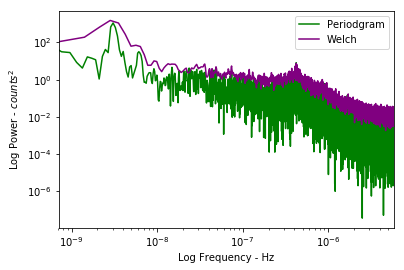

In [7]:
# number of points in Welch's method
nw  = 45*365.  
# overlap
nw_p= nw//2

# calculate the power spectra
#  using Welch's method
fw, pwspec = signal.welch(ssn, fs, nperseg=nw, noverlap=nw_p,   
                          window='blackmanharris', scaling='spectrum',detrend='linear')


# plot periodogram
f4, ax4 = plt.subplots()

ax4.plot(fp, p_spec, color='g', label='Periodgram')
ax4.plot(fw,pwspec,label='Welch', color='purple')
ax4.set(yscale='log',xlim=[fw[1],fw.max()],xscale='log')
ax4.set(ylabel='Log Power - $counts^2$',xlabel='Log Frequency - Hz')
ax4.legend()


Welch's method reduces the background, especially at higher frequencies. But there is a trade off, can anyone see what it is?


## The Spectrogram

What happens if the frequency content of a signal changes with time? 

This can occur is a signal in _nonstationary_ leading to a broadening of power in the spectra. Power spreads over multiple frequency bins.

The spectrogram allows the investigation of how a power spectra changes over time. 

Multiple spectra are calculated, each tagged with a time (either the beginning, middle or end of the power spectra window). 

This creates a timeseries of power where changes in power and frequency can be visualized as a function of time.  



Text(0,0.5,'Power')

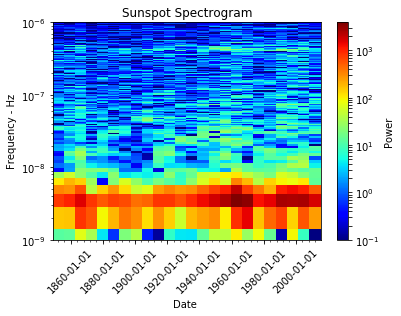

In [8]:
#import colors to change the color table
import matplotlib.colors as colors

# Use the spectrogram function to 
#  calculate the sunspot spectrogram 
nw = 22*365 # window lenght, ~22 years
nl = 16*365 # number of overlap points, ~16 years

f, t, s_spec = signal.spectrogram(ssn, fs,nperseg=nw, noverlap=nl,
                                  window='hanning', scaling='spectrum')

# create a new time axis
#  spectrogram returns t 
#  calculated from fs
d_spec = np.linspace(dates.min(),dates.max(),t.size)

#set parameters for date axis
year_a = mdates.YearLocator(20)   # every 20 years
year_b = mdates.YearLocator(4) # every 4 years
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y-%m-%d')

# create a figure for the spectrogram
f_spec, axs = plt.subplots()

spec = axs.pcolormesh(d_spec, f,s_spec,norm=colors.SymLogNorm(linthresh=0.03,vmin=0.1),cmap='jet')
axs.set_ylabel('Frequency - Hz')
axs.set_xlabel('Date ')
axs.set_title('Sunspot Spectrogram')
axs.set_ylim(1E-9,1E-6)
axs.set_yscale('log')
# format time ticks
axs.xaxis.set_major_locator(year_a) # set major ticks every 20 years
axs.xaxis.set_minor_locator(year_b) # set minor ticks every 4 years
axs.xaxis.set_major_formatter(yearsFmt) # format date axis
axs.xaxis.set_tick_params(rotation=45) # rotate for easier reading

# add a color bar
cbar = f_spec.colorbar(spec,ax=axs)
cbar.ax.set_ylabel('Power')



Not much evidence of varying frequencies. This is due to two reasons: 
1. We are isolating shorter frequencies. How so? 
1. Our time series is limited even with 150 years of data. Can anyone explain?

However with 150 years of data we can investigate how higher frequencies vary with time. 
For instance, do we see evidence of the solar rotation of sunspots varying with time?

What window and overlap could we use to concentrate on how higher frequencies change with time?  

In [9]:
# a simple smoothing function
#  convolves a box of length box_pts
#  with the input vector to smooth over
#  box_pts number of points
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

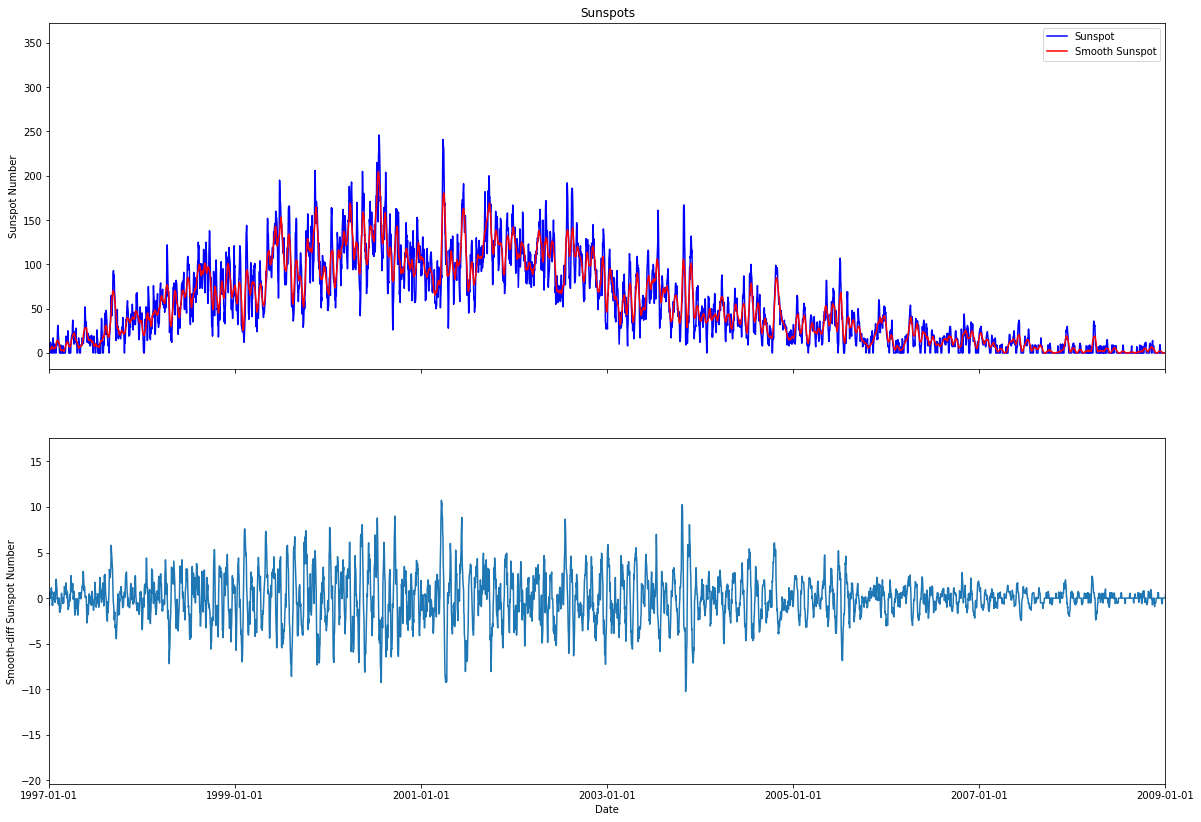

In [10]:
# After some testing
nw = 365 # window lenght, 365 days
nl = 30 # number of overlap points, 45 days

# smooth data to remover higher frequencies
s_sm  = smooth(ssn,15)
# difference data to remove shorter frequencies
s_dsm = np.diff(s_sm,1)


f2, t2, s_spec2 = signal.spectrogram(s_dsm, fs,nperseg=365, noverlap=45,
                                  window='blackmanharris', scaling='spectrum',detrend='constant')


# create a new time axis
#  spectrogram returns t 
#  calculated from fs
d_spec2 = np.linspace(dates.min(),dates.max(),t2.size)

#plot the time series
f5, ax5 = plt.subplots(2,figsize =(20,14), sharex=True)

ax5[0].plot(dates,ssn, c='b', label = 'Sunspot')
ax5[0].plot(dates,s_sm,c='r', label = 'Smooth Sunspot')
ax5[0].legend()
ax5[0].set(title='Sunspots',ylabel='Sunspot Number')

ax5[1].plot(dates[1:],s_dsm)
ax5[1].set(ylabel='Smooth-diff Sunspot Number', xlabel='Date')

# zoom in on x
xran = [datetime.strptime('19970101', '%Y%m%d'),datetime.strptime('20090101', '%Y%m%d')]
ax5[1].set_xlim(xran)

# format time ticks
ax5[1].xaxis.set_major_formatter(yearsFmt) # format date axis




Text(0,0.5,'Power')

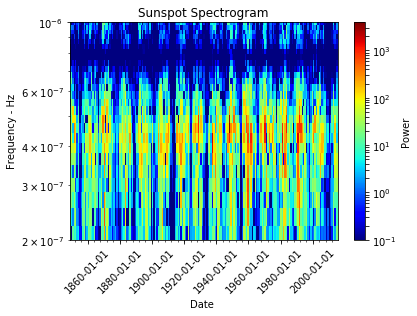

In [11]:
#plot power
f6, as2 = plt.subplots()

as2.pcolormesh(d_spec2, f2,s_spec2,norm=colors.SymLogNorm(linthresh=0.03, vmin =0.01),cmap='jet')
as2.set_ylabel('Frequency - Hz')
as2.set_xlabel('Date ')
as2.set_title('Sunspot Spectrogram')
as2.set_ylim(2E-7,1E-6)
as2.set_yscale('log')
# format time ticks
as2.xaxis.set_major_locator(year_a) # set major ticks every 20 years
as2.xaxis.set_minor_locator(year_b) # set minor ticks every 4 years
as2.xaxis.set_major_formatter(yearsFmt) # format date axis
as2.xaxis.set_tick_params(rotation=45) # rotate for easier reading

# add a color bar
cbar = f6.colorbar(spec,ax=as2)
cbar.ax.set_ylabel('Power')

In [14]:
print(f.shape, t.shape, s_spec.shape)

(4016,) (25,) (4016, 25)
